# Create a custom Speech-to-Text model for 💫 Your Voice 💫 with Common Voice

👋 Hello and welcome to Coqui Speech-to-Text (🐸STT). Check out [🐸STT on Github](https://github.com/coqui-ai/STT), and leave a star for new models and updates ⭐

This notebook shows you how to train a **custom, personal model** for **your voice** using **your data** from Common Voice.

In this notebook, we will:

1. Download your personal Common Voice data
2. Import your data into 🐸STT
3. Fine-tune an off-the-shelf 🐸STT model to your voice
4. Test your custom model and display performance

So, let's jump in!

## ⚠️ Caveats ⚠️

- *You can only download your data from Common Voice once every seven days, so plan accordingly.*
- *You should use a GPU*
- *This tutorial assumes your Common Voice data is in English. If you'd like to fine-tune a STT model in another language, you will need to download the appropriate pre-trained model checkpoints.*
- *This tutorial assumes you've recorded at least 100 sentences in Common Voice. If you've recorded more or less you should change the batch sizes. The more you record, the better.*

## ✅ Make sure you're using a GPU

On Colab you should have free GPU access, so let's use the power 🔥

Turn on the GPU runtime from the Google Colab menu as follows:

`Runtime >> Change runtime type >> Hardware Accelerator >> GPU`


## ✅ Download your data from Common Voice

To download data from Common Voice, you need to have a Common Voice account and you must have recorded some sentences. Log-in or Sign-up in the top right corner of [`commonvoice.mozilla.org`](https://commonvoice.mozilla.org)

Once you've logged in, you will see your username and avatar in the top right corner.

From the drop-down menu next to your username, click on "Profile".


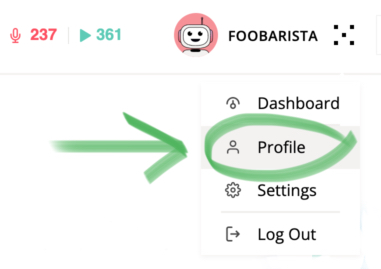


Next, click the "Download My Data" button.

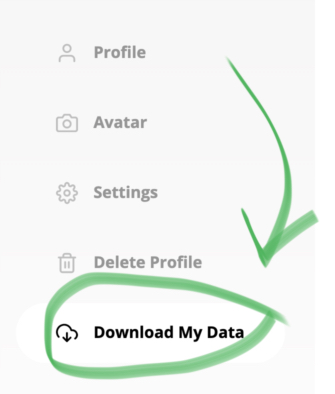

Next, push the "Request recordings" button.

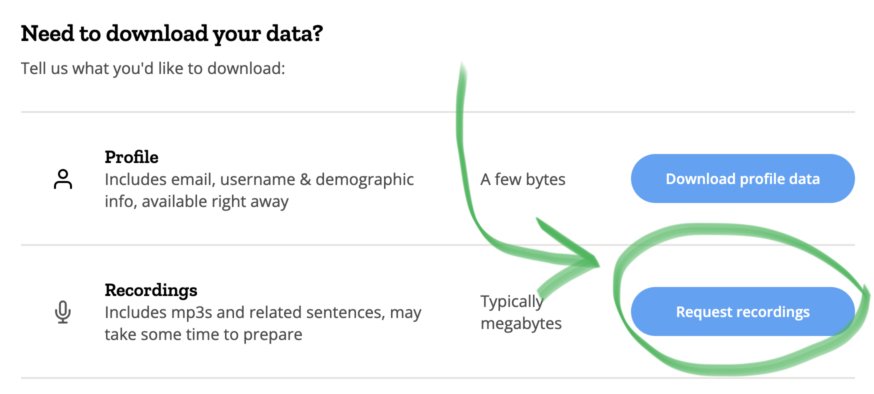

Next, click the "Download" button

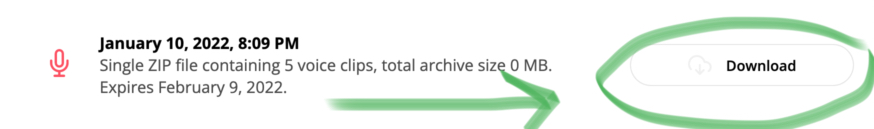

Finally you've made it!

You should see a download page with two URLs to your data bundles.

Copy and paste those two links into the code below, and let's get started!

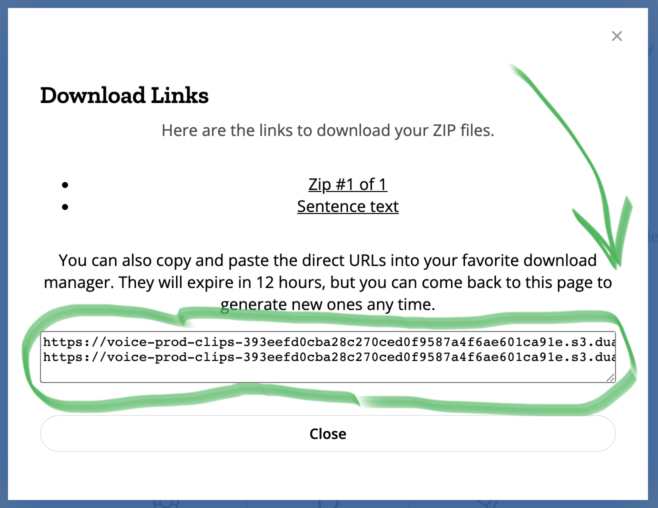

## ✅ Download your data to Colab

Just paste in the URLs you got from Common Voice into the code block below, and run it.

In [ ]:
from urllib import request
import os

FIRST_URL="Paste first super long URL here, but leave in the surrounding double quotes"
SECOND_URL="Paste second super long URL here, but leave in the surrounding double quotes"

FIRST_FILENAME = FIRST_URL.split("/")[-1].split("?")[0]
SECOND_FILENAME = SECOND_URL.split("/")[-1].split("?")[0]

if os.path.isfile(FIRST_FILENAME):
  print("Found", FIRST_FILENAME, ", skipping download.")
else:
  print("Downloading", FIRST_FILENAME, "...")
  request.urlretrieve(FIRST_URL, FIRST_FILENAME)

if os.path.isfile(SECOND_FILENAME):
  print("Found", SECOND_FILENAME, ", skipping download.")
else:
  print("Downloading", SECOND_FILENAME, "...")
  request.urlretrieve(SECOND_URL, SECOND_FILENAME)


### 👀 Take a look at your data

In [ ]:
# take a look at what you've downloaded
! ls .

## ✅ Install 🐸STT

In [ ]:
## Install Coqui STT
# dependencies
! apt-get install sox libsox-fmt-mp3 libopusfile0 libopus-dev libopusfile-dev
! pip install --upgrade pip
# the Coqui training package
! pip install coqui_stt_training
! pip uninstall -y tensorflow; pip install "tensorflow-gpu==1.15"
# code with importer scripts
! git clone --depth=1 https://github.com/coqui-ai/STT.git

## ✅ Import your data for 🐸STT



In [ ]:
# your *.txt and *.zip files will have different names, these are just examples
! python STT/bin/import_cv_personal.py --normalize takeout_*.txt takeout_*.zip

# now we're going to split the dataset into {train,dev,test} with auto_import_dataset
from coqui_stt_training.util.config import initialize_globals_from_args
import glob

DATA_CSV=glob.glob("/content/takeout_*/data.csv")[0]

initialize_globals_from_args(
    auto_input_dataset=DATA_CSV
)

## ✅ Download a pre-trained English 🐸STT model

In [ ]:
### Download pre-trained model
import os
import tarfile
from coqui_stt_training.util.downloader import maybe_download

def download_pretrained_model():
    model_dir="english/"
    if not os.path.exists("english/coqui-stt-1.1.0-checkpoint"):
        maybe_download("model.tar.gz", model_dir, "https://github.com/coqui-ai/STT/releases/download/v1.1.0/coqui-stt-1.1.0-checkpoint.tar.gz")
        print('\nNo extracted pre-trained model found. Extracting now...')
        tar = tarfile.open("english/model.tar.gz")
        tar.extractall("english/")
        tar.close()
    else:
        print('Found pre-trained 🐸STT model, skipping download.')

def download_language_model():
    model_dir="english/"
    if not os.path.exists("english/huge-vocabulary.scorer"):
        maybe_download("huge-vocabulary.scorer", model_dir, "https://github.com/coqui-ai/STT-models/releases/download/english/coqui/v1.0.0-huge-vocab/huge-vocabulary.scorer")
    else:
        print('Found 🐸STT language model, skipping download.')

# Download + extract pre-trained English model
download_pretrained_model()
download_language_model()

## ✅ Customize to your Voice

Let's kick off a training run 🚀🚀🚀 and fine-tune the pre-trained 🐸STT model to your unique voice.

In [ ]:
from coqui_stt_training.util.config import initialize_globals_from_args
from coqui_stt_training.train import train
import glob

TRAIN_CSV = glob.glob("/content/takeout_*/train.csv")
DEV_CSV = glob.glob("/content/takeout_*/dev.csv")

initialize_globals_from_args(
    load_checkpoint_dir="english/coqui-stt-1.1.0-checkpoint",
    save_checkpoint_dir="my-model/checkpoints",
    alphabet_config_path="english/coqui-stt-1.1.0-checkpoint/alphabet.txt",
    train_files=TRAIN_CSV,
    dev_files=DEV_CSV,
    epochs=10,
    load_cudnn=True,
    train_batch_size=32,
    dev_batch_size=32,
)

train()

## ✅ Test the model

We made it! 🙌

Let's kick off the testing run, and see how the model performs.

First, let's see how well the off-the-shelf English model recognizes your voice.

In [ ]:
# Test STT v1.0 on your voice data

from coqui_stt_training.util.config import initialize_globals_from_args
from coqui_stt_training.evaluate import test
import glob

TEST_CSV = glob.glob("/content/takeout_*/test.csv")

initialize_globals_from_args(
    load_checkpoint_dir="english/coqui-stt-1.1.0-checkpoint",
    scorer_path="english/huge-vocabulary.scorer",
    test_files = TEST_CSV,
    test_batch_size = 32,
)

test()

Now, let's see how much better ✨ your new custom model ✨ performs 🤩

In [ ]:
# Test your custom model on your held-out test data

from coqui_stt_training.util.config import initialize_globals_from_args
from coqui_stt_training.evaluate import test
import glob

TEST_CSV = glob.glob("/content/takeout_*/test.csv")

initialize_globals_from_args(
    load_checkpoint_dir="my-model/checkpoints",
    scorer_path="english/huge-vocabulary.scorer",
    test_files = TEST_CSV,
    test_batch_size=32,
)

test()

## 🤷‍♀️ What next?

Now that you've trained your own personal Speech-to-Text model, you can download the `my-model/checkpoints` directory to your local computer, and use it on your own computer without an internet connection!

The sky's the limit for what's possible, but if you want some inspiration, check out the [STT-examples](https://github.com/coqui-ai/stt-examples) collection of community examples with STT.

Happy hacking!

### from 🐸 with 💚